# Кластеризация 3

## Простая рекомендательная система

In [5]:
from sklearn import datasets
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

%matplotlib inline

# Зафиксируем случайность, чтобы у нас получались одинаковые результаты.
np.random.seed(seed=42)

In [6]:
movies = pd.read_csv('imdb_movies.csv.gz', index_col='movieId')
ratings = pd.read_csv('imdb_ratings.csv.gz')

print(movies.shape)
print(ratings.shape)

(9125, 2)
(100004, 4)


In [7]:
movies.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [8]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [9]:
from itertools import chain
'''
Нам нужна функция flatmap.
Flatmap получает на вход список, на каждом элементе вызывает функцию f, которая возвращает другой список.
В результате получается список списков. В конфе происходит flatten - уплощение списка скписков в один список.
'''
def flatmap(f, items):
    return chain.from_iterable(map(f, items))

# пример использования
list(flatmap(lambda x: [0, x , x*x], [1,2,3,4,5]))
# Первый шаг: [[0, 1, 1], [0, 2, 4], [0, 3, 9], [0, 4, 16], [0, 5, 25]]

[0, 1, 1, 0, 2, 4, 0, 3, 9, 0, 4, 16, 0, 5, 25]

In [10]:
# создаем функцию, которая просто разбивает строку по символу | на подстроки
def genre_splitter(genre_names):
    return genre_names.split("|")

m_uniq = movies['genres'].unique() # смотрим сколько всего уникальных комбинация genres есть в датасете
print("m_uniq[0:10] = {}\nlen= {}\n".format(m_uniq[0:10], len(m_uniq))) # как видим комбинаций очень много, так как там все композиции

genres = set(flatmap(genre_splitter, m_uniq)) # разбиваем все genres на составные части и генерируем один массив из всех жанров. Строим по массиву множество уникальных жанров

# выкидываем из множества ненужные элементы
genres.remove('(no genres listed)')
genres.remove('IMAX')

genres = list(genres) # множество превращаем в список
print("Genres={}\nlen={}".format(genres, len(genres)))

m_uniq[0:10] = ['Adventure|Animation|Children|Comedy|Fantasy'
 'Adventure|Children|Fantasy' 'Comedy|Romance' 'Comedy|Drama|Romance'
 'Comedy' 'Action|Crime|Thriller' 'Adventure|Children' 'Action'
 'Action|Adventure|Thriller' 'Comedy|Horror']
len= 902

Genres=['Thriller', 'Western', 'War', 'Animation', 'Sci-Fi', 'Film-Noir', 'Musical', 'Action', 'Drama', 'Adventure', 'Romance', 'Comedy', 'Horror', 'Crime', 'Mystery', 'Documentary', 'Children', 'Fantasy']
len=18


In [11]:
# Генерируем новую таблицу, где в колонках будет жанр, в строках фильм,
# а в ячейках 1 если у фильма есть этот жанр и 0 в противном случае

movies_genres = pd.DataFrame(index=movies.index)
for g in genres:
    movies_genres[g] = movies['genres'].str.contains(g).astype(int)
print(movies_genres.shape)
movies_genres.head()

(9125, 18)


,Thriller,Western,War,Animation,Sci-Fi,Film-Noir,Musical,Action,Drama,Adventure,Romance,Comedy,Horror,Crime,Mystery,Documentary,Children,Fantasy
movieId,,,,,,,,,,,,,,,,,,
1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,1
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1
3,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


Теперь соединим две таблицы:
1. жанры по каждому фильму
2. оценки фильмов от людей. Кстати, один человек мог посмотреть 1 фильм или 100, но не все!

Пусть `N` - это количество фильмов, а `M` - это количество отзывов пользователей. Тогда соединение этих двух таблиц будет иметь размер `N*M`.

In [12]:
df_m = ratings.join(movies_genres, on='movieId').drop(['timestamp', 'movieId'], axis=1)
df_m[genres] = df_m[genres].multiply(df_m['rating'], axis='index')
df_m = df_m.drop(['rating'], axis=1).replace(0, np.NaN) # чтобы посчитать mean без учета непросмотренных фильмов
df_m.head()

,userId,Thriller,Western,War,Animation,Sci-Fi,Film-Noir,Musical,Action,Drama,Adventure,Romance,Comedy,Horror,Crime,Mystery,Documentary,Children,Fantasy
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,3.0,NaN,NaN,3.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
2,1,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2.0,NaN,NaN,NaN,2.0,NaN,NaN,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


С такой таблицей `N*M` вы всё еще не можем работать.  
Сгруппируем строки по пользователям (колонка `userId`).  
В группах посчитаем среднюю оценку на жанр. А если пользователь не смотрел фильм, то поставим ему `-1` в соответсвующую ячейку.

In [13]:
df = df_m.groupby('userId').mean()
df.fillna(-1, inplace=True)
print(df.shape)
df.head()

(671, 18)


,Thriller,Western,War,Animation,Sci-Fi,Film-Noir,Musical,Action,Drama,Adventure,Romance,Comedy,Horror,Crime,Mystery,Documentary,Children,Fantasy
userId,,,,,,,,,,,,,,,,,,
1,2.833333,3.0,2.000000,2.000000,2.400000,-1.0,3.000000,2.800000,2.571429,2.166667,3.500000,2.000000,3.000000,2.500000,-1.000000,-1.000000,2.500000,2.125000
2,3.333333,5.0,3.800000,3.666667,3.800000,-1.0,3.750000,3.315789,3.615385,3.750000,3.590909,3.093750,3.500000,3.666667,4.000000,-1.000000,3.500000,3.400000
3,3.545455,4.0,4.166667,2.875000,3.142857,-1.0,2.500000,3.468750,3.920000,3.300000,3.650000,3.611111,3.375000,3.700000,3.750000,3.666667,2.700000,3.000000
4,4.022727,3.0,4.750000,4.708333,4.255814,5.0,4.833333,4.274194,4.464286,4.338710,4.500000,4.329545,3.944444,4.157895,4.090909,4.000000,4.634146,4.567568
5,3.625000,-1.0,4.000000,3.900000,4.000000,-1.0,4.250000,4.000000,3.807692,3.825000,4.081081,3.981818,3.875000,3.450000,3.333333,3.666667,3.892857,3.750000


Прежде чем начать обучать kMeans, нужно отмасштабировать признаки.

Как мы знаем по лекции, метрические алгоритмы, которым является kMeans, лучше подавать на вход данные одного масштаба.  Этим и занимается метод MinMaxScaler.

Алгоритм его работы:
```
X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X_scaled = X_std * (max - min) + min
```

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

clf = KMeans(n_clusters=5)
clf.fit(scaler.fit_transform(df))

KMeans(n_clusters=5)

Нарисуем на графике центры кластеров нашего датасета оценок фильмов.

В нем будет 5 строчек - 5 кластеров. И 18 столбцов - 18 жанров фильмов.

Из графика мы поймем какие жанры обычно смотрят вместе. По сути мы получили кластеры предпочтений людей.

Index(['Thriller', 'Western', 'War', 'Animation', 'Sci-Fi', 'Film-Noir',
       'Musical', 'Action', 'Drama', 'Adventure', 'Romance', 'Comedy',
       'Horror', 'Crime', 'Mystery', 'Documentary', 'Children', 'Fantasy'],
      dtype='object')


<Axes: >

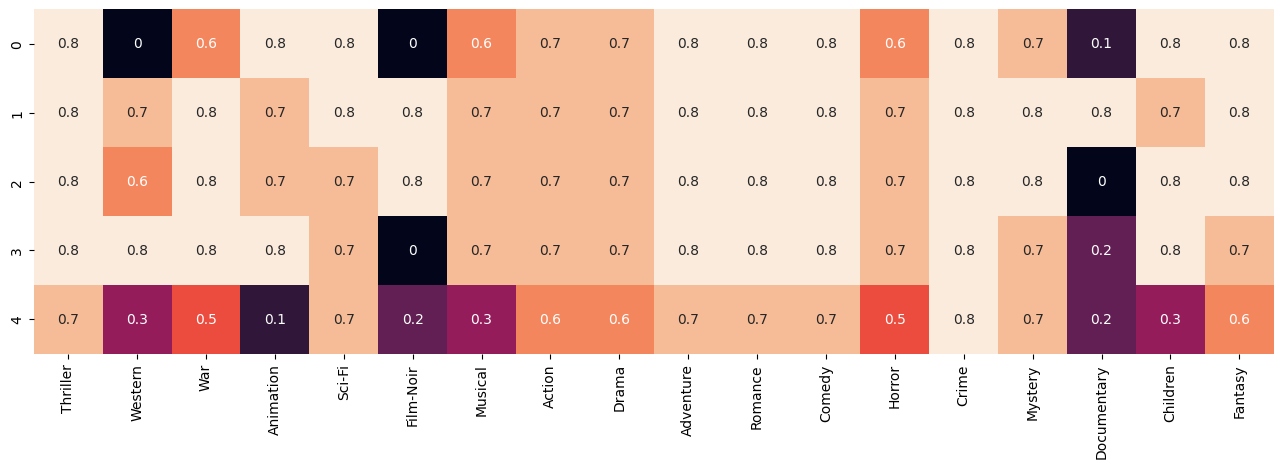

In [15]:
plt.figure(figsize=(16,10))
print(df.columns)
sns.heatmap(np.round(clf.cluster_centers_, 1), annot=True, square=True, cbar=False, xticklabels=df.columns)

## Кластеризация признаков

В предыдущем примере мы нашли кластеры похожих в предпочтениях людей. Теперь попробуем найти похожие жанры, основываясь на рейтингах людей, если это, конечно, возможно.

In [16]:
df = df_m.groupby('userId').mean()
df.fillna(0, inplace=True)
print(df.shape)
df.head()

(671, 18)


,Thriller,Western,War,Animation,Sci-Fi,Film-Noir,Musical,Action,Drama,Adventure,Romance,Comedy,Horror,Crime,Mystery,Documentary,Children,Fantasy
userId,,,,,,,,,,,,,,,,,,
1,2.833333,3.0,2.000000,2.000000,2.400000,0.0,3.000000,2.800000,2.571429,2.166667,3.500000,2.000000,3.000000,2.500000,0.000000,0.000000,2.500000,2.125000
2,3.333333,5.0,3.800000,3.666667,3.800000,0.0,3.750000,3.315789,3.615385,3.750000,3.590909,3.093750,3.500000,3.666667,4.000000,0.000000,3.500000,3.400000
3,3.545455,4.0,4.166667,2.875000,3.142857,0.0,2.500000,3.468750,3.920000,3.300000,3.650000,3.611111,3.375000,3.700000,3.750000,3.666667,2.700000,3.000000
4,4.022727,3.0,4.750000,4.708333,4.255814,5.0,4.833333,4.274194,4.464286,4.338710,4.500000,4.329545,3.944444,4.157895,4.090909,4.000000,4.634146,4.567568
5,3.625000,0.0,4.000000,3.900000,4.000000,0.0,4.250000,4.000000,3.807692,3.825000,4.081081,3.981818,3.875000,3.450000,3.333333,3.666667,3.892857,3.750000


In [17]:
df.T

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
Thriller,2.833333,3.333333,3.545455,4.022727,3.625000,2.722222,3.000000,4.075758,3.600000,3.500000,...,3.052632,3.687500,3.811203,3.175676,3.071429,3.500000,4.500000,3.076923,3.900000,4.052632
Western,3.000000,5.000000,4.000000,3.000000,0.000000,0.000000,2.500000,0.000000,0.000000,2.000000,...,3.000000,0.000000,4.166667,3.222222,4.000000,3.000000,0.000000,5.000000,1.000000,3.500000
War,2.000000,3.800000,4.166667,4.750000,4.000000,4.166667,3.600000,4.083333,3.666667,4.000000,...,4.666667,4.000000,3.661290,3.615385,3.333333,3.833333,4.500000,0.000000,4.333333,3.857143
Animation,2.000000,3.666667,2.875000,4.708333,3.900000,3.500000,4.083333,3.500000,3.333333,0.000000,...,3.666667,4.333333,3.775000,3.717391,2.500000,4.000000,3.000000,0.000000,4.000000,4.250000
Sci-Fi,2.400000,3.800000,3.142857,4.255814,4.000000,2.750000,3.360000,4.038462,4.250000,3.875000,...,3.000000,3.812500,3.805732,3.357143,2.800000,4.250000,0.000000,2.875000,3.750000,4.041667
Film-Noir,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,3.500000,0.000000,0.000000,...,0.000000,0.000000,3.833333,0.000000,0.000000,0.000000,0.000000,5.000000,1.500000,0.000000
Musical,3.000000,3.750000,2.500000,4.833333,4.250000,3.000000,3.500000,3.500000,4.000000,3.000000,...,3.666667,0.000000,3.500000,3.828571,2.500000,3.666667,0.000000,0.000000,0.000000,4.250000
Action,2.800000,3.315789,3.468750,4.274194,4.000000,3.266667,3.285714,3.967742,3.250000,3.666667,...,2.833333,3.727273,3.769841,3.342105,2.846154,3.266667,3.500000,3.777778,3.600000,4.000000
Drama,2.571429,3.615385,3.920000,4.464286,3.807692,3.550000,3.517241,3.767241,4.000000,4.066667,...,3.791667,3.687500,3.849765,3.374332,3.142857,3.707317,4.307692,3.416667,3.764706,3.778846
Adventure,2.166667,3.750000,3.300000,4.338710,3.825000,3.733333,3.656250,3.863636,3.166667,3.923077,...,3.200000,3.875000,3.796154,3.445783,3.100000,3.571429,3.000000,3.800000,3.400000,4.086207


In [18]:
scaler = MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(df.T)

Выберем количество кластеров с помощью алгоритма силуэта

In [19]:
from sklearn.metrics import silhouette_score, silhouette_samples

def draw_sil_score(X, range_n_clusters=[2, 3, 4, 5, 6, 10, 12, 13, 20]):
    scores = []
    for n_clusters in range_n_clusters:
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        scores.append(silhouette_avg)
    plt.plot(range_n_clusters, scores)
    return range_n_clusters[np.argmax(scores)]

3

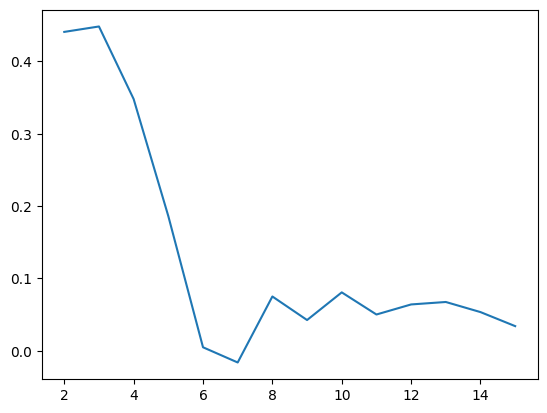

In [20]:
draw_sil_score(X,range(2,16))

Очевидно, что оптимальное количество кластеров это 2. Но нас не интересует такое разбиение. Можно поробовать 4 или 8 кластеров.

In [21]:
clf = KMeans(n_clusters=4)
clf.fit(X)

KMeans(n_clusters=4)

Посмотрим на группы "похожих" жанров фильмов на основе оценок пользователей.

In [22]:
clusters = pd.DataFrame(index=df.T.index).reset_index()
clusters['label'] = clf.labels_
for el in clusters.groupby('label')['index'].apply(lambda x: ' '.join(x)).values:
    print(el)

Animation Musical Children
Film-Noir Documentary
Thriller War Sci-Fi Action Drama Adventure Romance Comedy Horror Crime Mystery Fantasy
Western


Выборка была судя по всему сильно смещеной, поэтому мы получили 4 кластера:
- всякие экшоны
- документалка и нуар
- детские фильмы, анимация и мюзиклы
- вестерн (wat?)

В принципе логично, так как данные не сбалансированны.

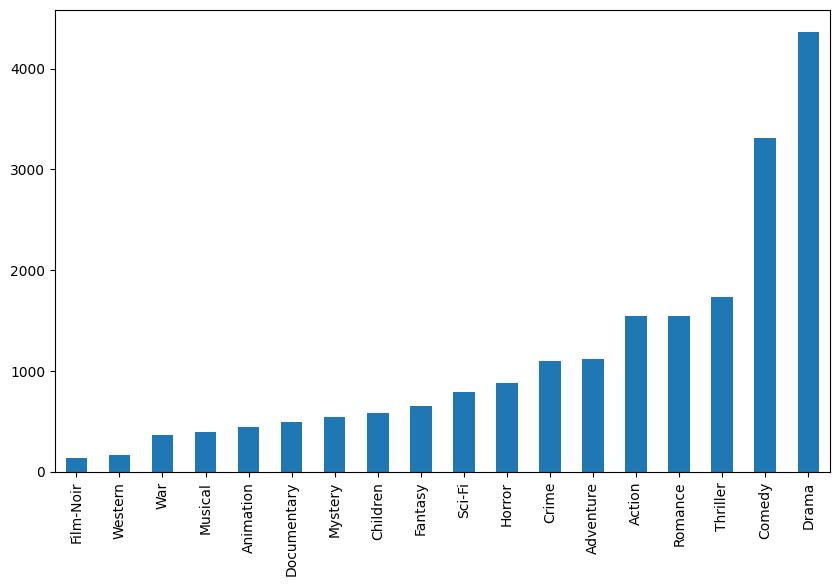

In [23]:
plt.figure(figsize=(10,6))
_ =movies_genres.sum().sort_values().plot(kind='bar')

Посмотрим на визуализацию объектов в такой выборке - то есть как расположены в пространстве фильмы по их жанрам.

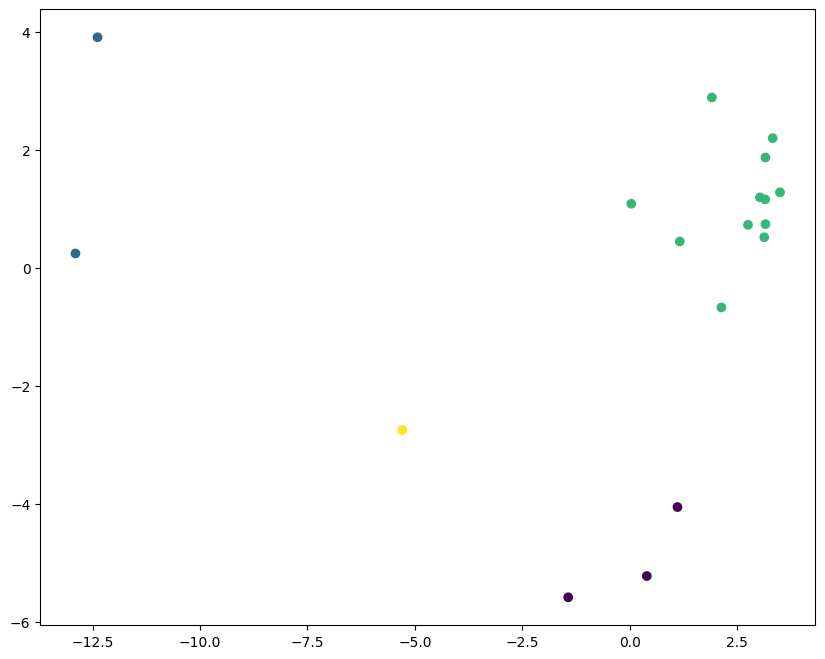

In [24]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
df_pca = pca.fit_transform(X)

plt.figure(figsize=(10,8))
plt.scatter(df_pca[:,0], df_pca[:,1],c=clf.labels_)

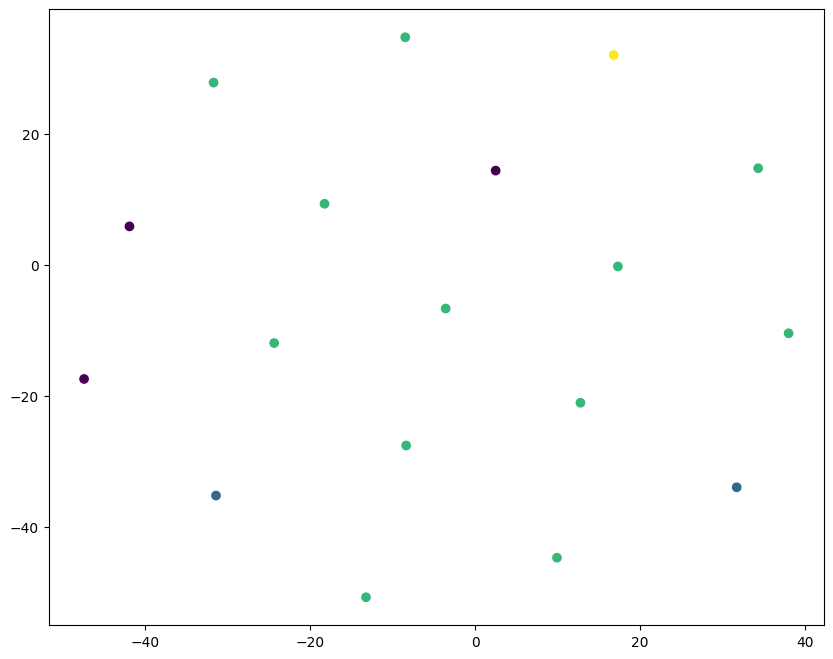

In [26]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, init='pca', perplexity=len(X) - 1)
df_tsne = tsne.fit_transform(X)

plt.figure(figsize=(10,8))
plt.scatter(df_tsne[:,0], df_tsne[:,1], c=clf.labels_)

![](http://tech.krutovtalks.ru/content/images/2017/06/hate.jpg)